In [3]:
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import pandas as pd
import sys
sys.path.append("..")
import torch
from torch import nn

from lib import data
from lib import sar
from lib import io

from torch import nn  
from loguru import logger
from lib.datamodules.components import scatterdataset
from lib.datamodules import scatterdatamodule
from lib.models import scattermodel
from omegaconf import OmegaConf
import hydra
import pprint
from importlib import reload
reload(scatterdataset)

<module 'lib.datamodules.components.scatterdataset' from '/home/ubuntu/sar-recovery/notebooks/../lib/datamodules/components/scatterdataset.py'>


**Quad-Pol SAR Data Reconstruction from Dual-Pol SAR Mode Based on a Multiscale Feature Aggregation Network**, https://www.mdpi.com/2072-4292/15/17/4182

$$
S=
\begin{bmatrix}
S_{HH} & S_{HV} \\
S_{VH} & S_{VV} \\
\end{bmatrix}
$$

$$
C=
\begin{bmatrix}
\langle |S_{HH}|^2 \rangle & \sqrt{2} \langle S_{HH}S^{*}_{HV} \rangle &  \langle S_{HH}S^{*}_{VV}\rangle \\
\sqrt{2} \langle S_{HV}S^{*}_{HH} \rangle &  2 \langle |S_{HV}|^2 \rangle  & \sqrt{2} \langle S_{HV}S^{*}_{VV} \rangle \\
\langle S_{VV}S^{*}_{HH} \rangle & \sqrt{2} \langle S_{VV}S^{*}_{HV}\rangle & \langle |S_{VV}|^2 \rangle
\end{bmatrix}
$$

## load hydra conf

In [4]:
conf = OmegaConf.load("../configs/scatter2scatter.yaml")
pprint.pp(OmegaConf.to_container(conf))

{'dataloader': {'_target_': 'lib.datamodules.scatterdatamodule.ScatterPatchesDataModule',
                'base_path': '/home/rlx/data/sar-recovery',
                'date_train': 20100520,
                'date_test': 20120720,
                'date_val': 20120720,
                'input_elems': ['Svv', 'Svh'],
                'output_elems': ['Shh'],
                'patch_size': 60,
                'splitmask_fn_src': 'lambda h, w: '
                                    'data.cv_splitpixels_spatial(h, w, '
                                    'pixels_train = 70, pixels_test = 15, '
                                    'pixels_val = 15, angle = np.pi/4)'},
 'model': {'_target_': 'lib.models.scattermodel.Scatter2Scatter',
           'in_channels': 2}}


## instantiate dataloader

In [5]:
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-17 20:50:06.531 | INFO     | lib.datamodules.components.scatterdataset:__init__:115 - loading scatter matrix
2024-04-17 20:50:10.026 | WARNING  | lib.datamodules.components.patches:__init__:75 - split proportions changed too much during patch split
ScatterPatchesDataset       patch_size=60  splitmask_dims=(4402, 1602)
original split proportions: train=0.700  test=0.150  val=0.150
patch split proportions:    train=1.000  test=0.000  val=0.000
        
2024-04-17 20:50:10.027 | INFO     | lib.datamodules.components.scatterdataset:__init__:126 - scatter matrix shape is (4402, 1602, 2, 2), input elems [('Svv', [1, 1]), ('Svh', [1, 0])], output elems [('Shh', [0, 0])]
2024-04-17 20:50:10.028 | INFO     | lib.datamodules.components.scatterdataset:__init__:115 - loading scatter matrix
2024-04-17 20:50:13.579 | WARNING  | lib.datamodules.components.patches:__init__:75 - split proportions changed too much during patch split
ScatterPatchesDataset       patch_size=60  splitmask_dims=(4402

In [6]:
b = next(iter(dl.train_dataloader()))
{k:v.shape for k,v in b.items()}

{'input_patch': torch.Size([16, 2, 60, 60]),
 'output_patch': torch.Size([16, 1, 60, 60]),
 'patch_coords': torch.Size([16, 2])}

## instantiate model

In [7]:
m = hydra.utils.instantiate(conf.model)

## train loop

In [8]:
dtr = dl.train_dataloader()

optimizer = torch.optim.Adam(m.parameters(), lr=5e-4)

complex_rmse_loss_fn = lambda y_true, y_pred: torch.sqrt(torch.mean((y_pred-y_true)*(y_pred-y_true).conj()).real)

nparams = sum([len(p.flatten()) for p in m.parameters()])
print (f"number of model parameters {nparams}")

number of model parameters 26446


In [9]:
n_epochs = 10

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dtr):
        # extract data from batch
        x = batch['input_patch']
        t = batch['output_patch']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = complex_rmse_loss_fn(t, o)

        #loss = torch.sqrt(torch.mean( (torch.log(o.real + 1e-5) - torch.log(t.real + 1e-5))**2 ))

        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        ogt0 = (o.real.detach().numpy()>0).mean()
        tgt0 = (t.real.detach().numpy()>0).mean()
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-10:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f} o>0 {ogt0:.3f} t>0 {tgt0:.3f}", end="\r")
        
    print()

epoch   0 step 118 loss 193.85188 params 0.2747282 o>0 0.318 t>0 0.494
epoch   1 step 118 loss 197.72334 params 0.3248646 o>0 0.103 t>0 0.500
epoch   2 step 118 loss 197.20204 params 0.3776456 o>0 0.011 t>0 0.501
epoch   3 step 118 loss 205.67905 params 0.4386772 o>0 0.018 t>0 0.494
epoch   4 step 118 loss 197.13655 params 0.5021862 o>0 0.013 t>0 0.498
epoch   5 step 118 loss 195.94495 params 0.5643177 o>0 0.011 t>0 0.498
epoch   6 step 118 loss 186.14886 params 0.6266004 o>0 0.001 t>0 0.502
epoch   7 step 118 loss 176.00182 params 0.6874266 o>0 0.005 t>0 0.493
epoch   8 step 118 loss 186.63034 params 0.7431998 o>0 0.000 t>0 0.504
epoch   9 step 118 loss 198.71907 params 0.7980381 o>0 0.000 t>0 0.504


Text(0, 0.5, 'loss')

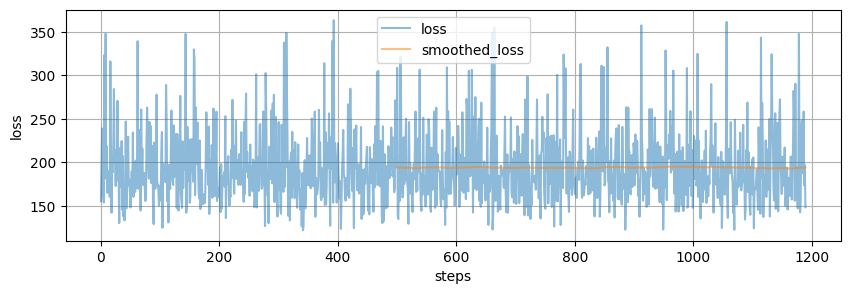

In [10]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(500).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")


/tmp/ipykernel_1267/3456097985.py:3: RuntimeWarning: overflow encountered in exp
  plt.scatter(np.exp(_t), np.exp(_o), s=10, alpha=.5);


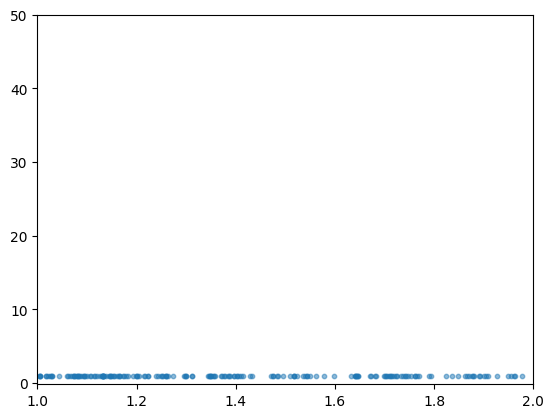

In [11]:
_t = t.real.detach().numpy().flatten()
_o = o.real.detach().numpy().flatten()
plt.scatter(np.exp(_t), np.exp(_o), s=10, alpha=.5);
plt.ylim(-.2,50)
plt.xlim(1.,2);

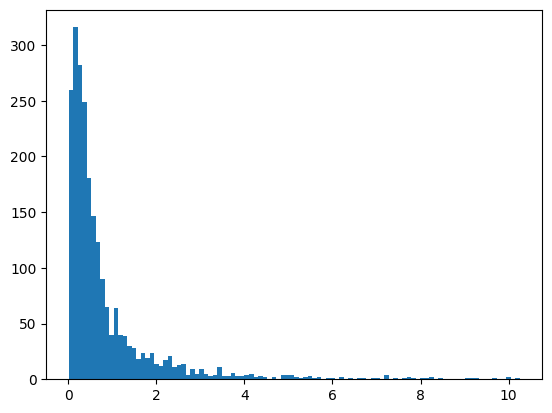

In [49]:
_t = t.real.detach().numpy().flatten()
a,b = np.percentile(_t, [0,99])
_t = _t[(_t>=a) & (_t<=b)]
plt.hist(_t, bins=100);

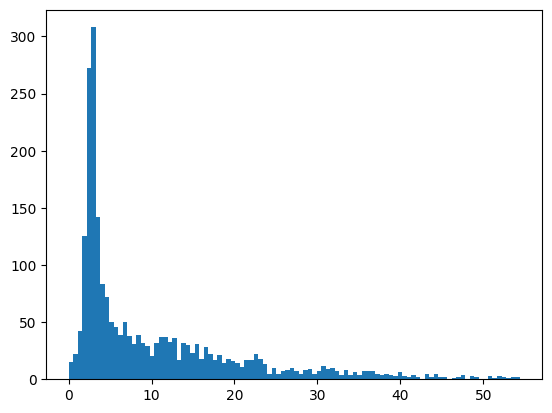

In [50]:
_o = o.real.detach().numpy().flatten()
a,b = np.percentile(_o, [0,99])
_o = _o[(_o>=a) & (_o<=b)]
plt.hist(_o, bins=100);

In [107]:
(o.real.detach().numpy()>0).mean()

0.12152777777777778